March 2023

In this notebook, I'll walk through an example of how to import Python packages, read and manipulate a netcdf file, and create a plot of temperatures simulated by a climate model. In the blank sections below, use this example as a template to do the same for precipitation.

## Load Python packages

You only need to do this once at the top of any Python script or Jupyter notebook

In [31]:
import xarray as xr
import netCDF4 as nc
import numpy as np

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import cm

# settings
%config InlineBackend.figure_format = 'retina'

# Example for slicing and plotting Rocky Mountain topography data

## Open temperature data

In [8]:
# netcdf file name
dfile = 'ts.MERRA2.E2.1_grid.monthly.nc'

# read in the netcdf file with xarray
ds    = xr.open_dataset(dfile)

# extract 'TS', 'lat', and 'lon' variables from the dataset
lat   = ds.lat
lon   = ds.lon
month = ds.month
air_temp  = ds.TS

One nice aspect of the xarray package is that you can see information about data variables by simply writing the name of the variable in a cell and running it. Try it here for the surface air temperature data:

In [9]:
air_temp

<xarray.DataArray 'ts' (month: 12, lat: 361, lon: 576)>
[2495232 values with dtype=float32]
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    long_name:       surface_skin_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]

The file 'diagnostic_vars_2680-2999.E2pt1_PIctrl_restart.nc' contains many other climate variables in addition to temperature. If you want to play around with plotting some of those, you can similarly get information about the variable names by writing in the dataset name and running the cell: 

In [10]:
ds

<xarray.Dataset>
Dimensions:  (month: 12, lat: 361, lon: 576, lev: 42)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
Data variables: (12/18)
    ts       (month, lat, lon) float32 ...
    slp      (month, lat, lon) float32 ...
    u2m      (month, lat, lon) float32 ...
    u10m     (month, lat, lon) float32 ...
    v2m      (month, lat, lon) float32 ...
    v10m     (month, lat, lon) float32 ...
    ...       ...
    H        (month, lev, lat, lon) float32 ...
    OMEGA    (month, lev, lat, lon) float32 ...
    QV       (month, lev, lat, lon) float32 ...
    T        (month, lev, lat, lon) float32 ...
    U        (month, lev, lat, lon) float32 ...
    V        (month, lev, lat, lon) float32 ...
Attributes:
    description:     2D MERRA-2 MONTHLY CLIMATOLOGIES FROM MONTHLY MEAN OUTPUT
    data_span:       Jan-1980 -> Dec-2022
    date_generated:  February 08, 2024, 02:11:29 PM

## Slice data over the Rocky Mountains

In [11]:
# define North America lat-lon boundaries (30°-60°N, 130°W-100°W)
lat_min = 30  
lat_max = 60
lon_min = -130 
lon_max = -100 

# slice temperature data
air_temp_rm = air_temp.sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))

## Plot Rocky Mountain Air Temperature as a Map

Because we sliced the data, we should only have contours plotted for grid cells within the pre-defined lat and lon bounds. 

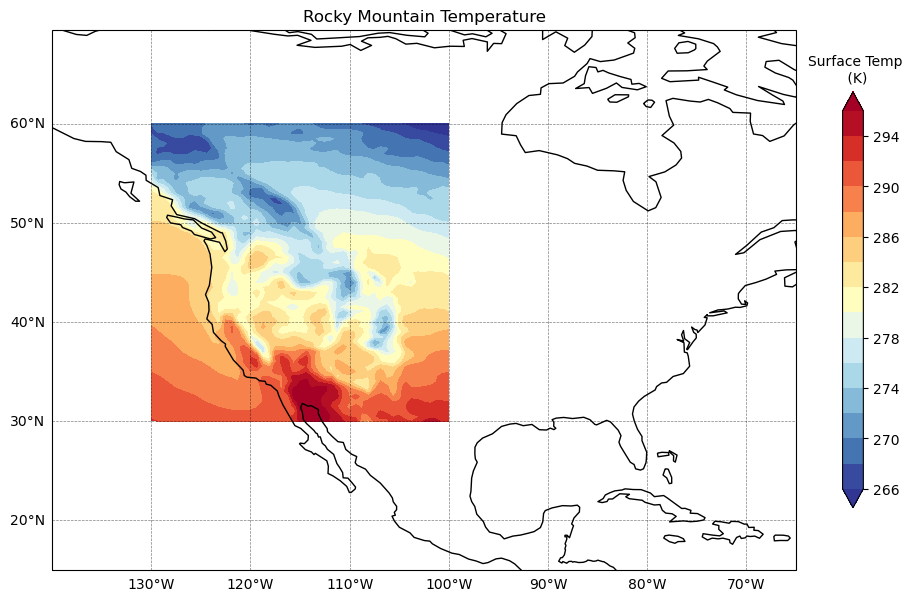

In [14]:
# Define map projection using Cartopy
trans = ccrs.PlateCarree()
proj  = ccrs.PlateCarree()

# Set figure and axes properties
fig = plt.figure(figsize=(12, 9))
ax  = plt.subplot(111, projection=proj)
ax.set_title(("Rocky Mountain Temperature"))

# Set colormap properties
cmap = plt.get_cmap('RdYlBu_r')
levels = 20

# Plot contours of Rocky Mountain mean annual surface temperature
cf = ax.contourf(air_temp_rm.lon, air_temp_rm.lat, air_temp_rm.mean(dim="month"),
                 cmap=cmap, levels=levels, extend='both',
                 transform=trans)
# Plot colorbar
cbar = fig.colorbar(cf, shrink=0.6, orientation='vertical',ax=ax)
cbar.set_label('Surface Temp\n (K)', labelpad=-32, y=1.15, rotation=0)

# Add coastlines and set map boundaries
ax.coastlines()
ax.set_extent([-140, -65, 15, 65])
gl = ax.gridlines(crs=trans, linewidth=.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False; gl.right_labels = False;


## Plot Rocky Mountain Air Temperature as a timeseries

The surface air temperature data has 3-dimensions (lat, lon, time). 
To plot a timeseries of surface air temperature for the whole region, we therefore need to take the mean along the lat and lon dimensions

BUT, since the size of grid-cells are not uniform, need to take a *weighted* mean of any spatially-gridded dataset

In [17]:
# determine weights based on latitude value
weights = np.cos(np.deg2rad(lat))
weights.name = 'weights'

## Rocky Mountain region
# calculate area-weighted values
air_temp_rm_weighted = air_temp_rm.weighted(weights)
# calculate mean of weighted data
air_temp_rm_weighted_mean = air_temp_rm_weighted.mean(dim=['lat','lon'], keep_attrs=True)

## taking the average of the original temp variable will give us a global mean surface temperature
## curve to compare the Rocky Mountain data to
# calculate area-weighted values
air_temp_global_weighted = air_temp.weighted(weights)
# calculate mean of weighted data
air_temp_global_weighted_mean = air_temp_global_weighted.mean(dim=['lat','lon'], keep_attrs=True)

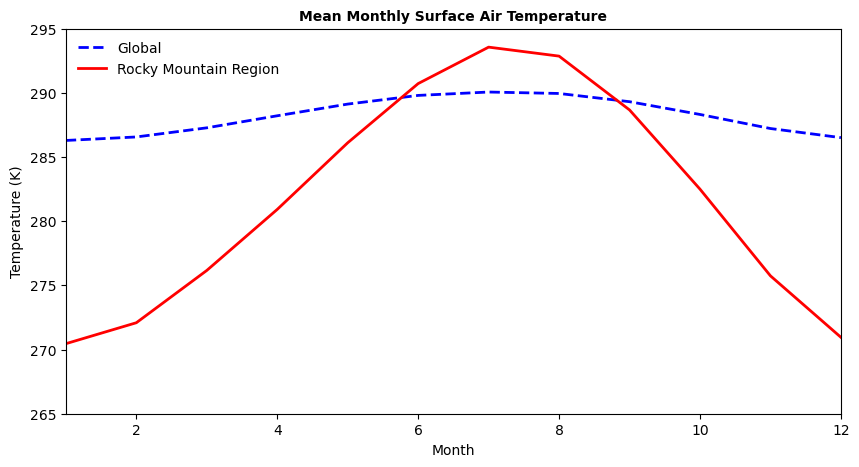

In [18]:
# plot the data

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.set_title(("Mean Monthly Surface Air Temperature"), fontsize=10, fontweight='bold')

ax.plot(month, air_temp_global_weighted_mean, color='blue', linewidth=2, linestyle='--', label='Global')
ax.plot(month, air_temp_rm_weighted_mean, color='red', linewidth=2, linestyle='-', label='Rocky Mountain Region')

ax.set(xlabel='Month', xlim=[1,12],
       ylabel='Temperature (K)', ylim=[265,295])

ax.legend(loc='upper left', frameon=False, fontsize=10)


# Slicing and plotting precipitation data over South America

The file 'imerg.gissE2pt1_grid.nc' contains global precipitation data. Using the example above, try reading it in and making a plot of rainfall over the Andes Mountains.

## Open dataset and create precipitation variable

In [ ]:
# netcdf file name
dfile = 'imerg.gissE2pt1_grid.nc'

# read in the netcdf file with xarray


# extract 'precipitation', 'month', 'lat', and 'lon' variables from the dataset


## Slice data over western South America

In [ ]:
# define western South American lat-lon boundaries (lat: 53°S-10°N, lon: 82°W-62°W)


# slice precipitation data


## Plot western South American Rainfall

In [ ]:
# Define map projection using Cartopy
trans = ccrs.PlateCarree()
proj  = ccrs.PlateCarree()

# Set figure and axes properties
fig = plt.figure(figsize=(12, 9))
ax  = plt.subplot(111, projection=proj)
ax.set_title(("Western South American Rainfall"))

# Set colormap properties
cmap = plt.get_cmap('Blues')
levels = 25

# Plot contours of Rocky Mountain topography



# Plot colorbar



# Add coastlines and set map boundaries
ax.coastlines()
ax.set_extent([-90, -50, -55, 15])
gl = ax.gridlines(crs=trans, linewidth=.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False; gl.right_labels = False;

# Plotting Wind Direction and Speed

Because wind is a vector, it has both a magnitude and direction. Wind data is thus often broken down into it's eastward ($U$) and northward ($V$) components. Sometimes the wind speed magnitude is output as a separate variable, but wind speed can also be calculated according to this formula:

$speed = \sqrt{(U^2 + V^2)}$

## Read in data and create variables for wind components and speed

In [61]:
# netcdf file name
dpath = '/Users/dervlamk/OneDrive/research/obs_data/reanalysis/merra2/'
dfile = 'merra2.sfcWinds.1980-2022.monthly.nc'

# read in the netcdf file with xarray
ds    = xr.open_dataset(f'{dpath}/{dfile}')

# extract 'U10M', 'V10M', '', time', lat', and 'lon' variables from the dataset
lat      = ds.lat
lon      = ds.lon
time     = ds.time
u10      = ds.U10M       # 10 m horizontal wind component
v10      = ds.V10M       # 10 m horizontal wind component
wndSpd10 = ds.windSpd10m # 10 m wind speed
wndSpd2  = ds.windSpd2m # 10 m wind speed

## Calculate climatologies

The MERRA-2 reanalysis data you just read in is a timeseries with one data point per month for 1980--2022. We want to calculate the average climatology per month and season over this period.

In [62]:
# calculate monthly climatologies
u10_monthly      = u10.groupby("time.month").mean()
v10_monthly      = v10.groupby("time.month").mean()
wndSpd10_monthly = wndSpd10.groupby("time.month").mean()
wndSpd2_monthly  = wndSpd2.groupby("time.month").mean()

# calculate seasonal climatologies
u10_seas      = u10.groupby("time.season").mean()
v10_seas      = v10.groupby("time.season").mean()
wndSpd10_seas = wndSpd10.groupby("time.season").mean()
wndSpd2_seas  = wndSpd2.groupby("time.season").mean()

In [63]:
wndSpd2_monthly  = wndSpd2.groupby("time.month").mean()
wndSpd2_seas  = wndSpd2.groupby("time.season").mean()

## Create a plot of wind speed contours and direction vectors

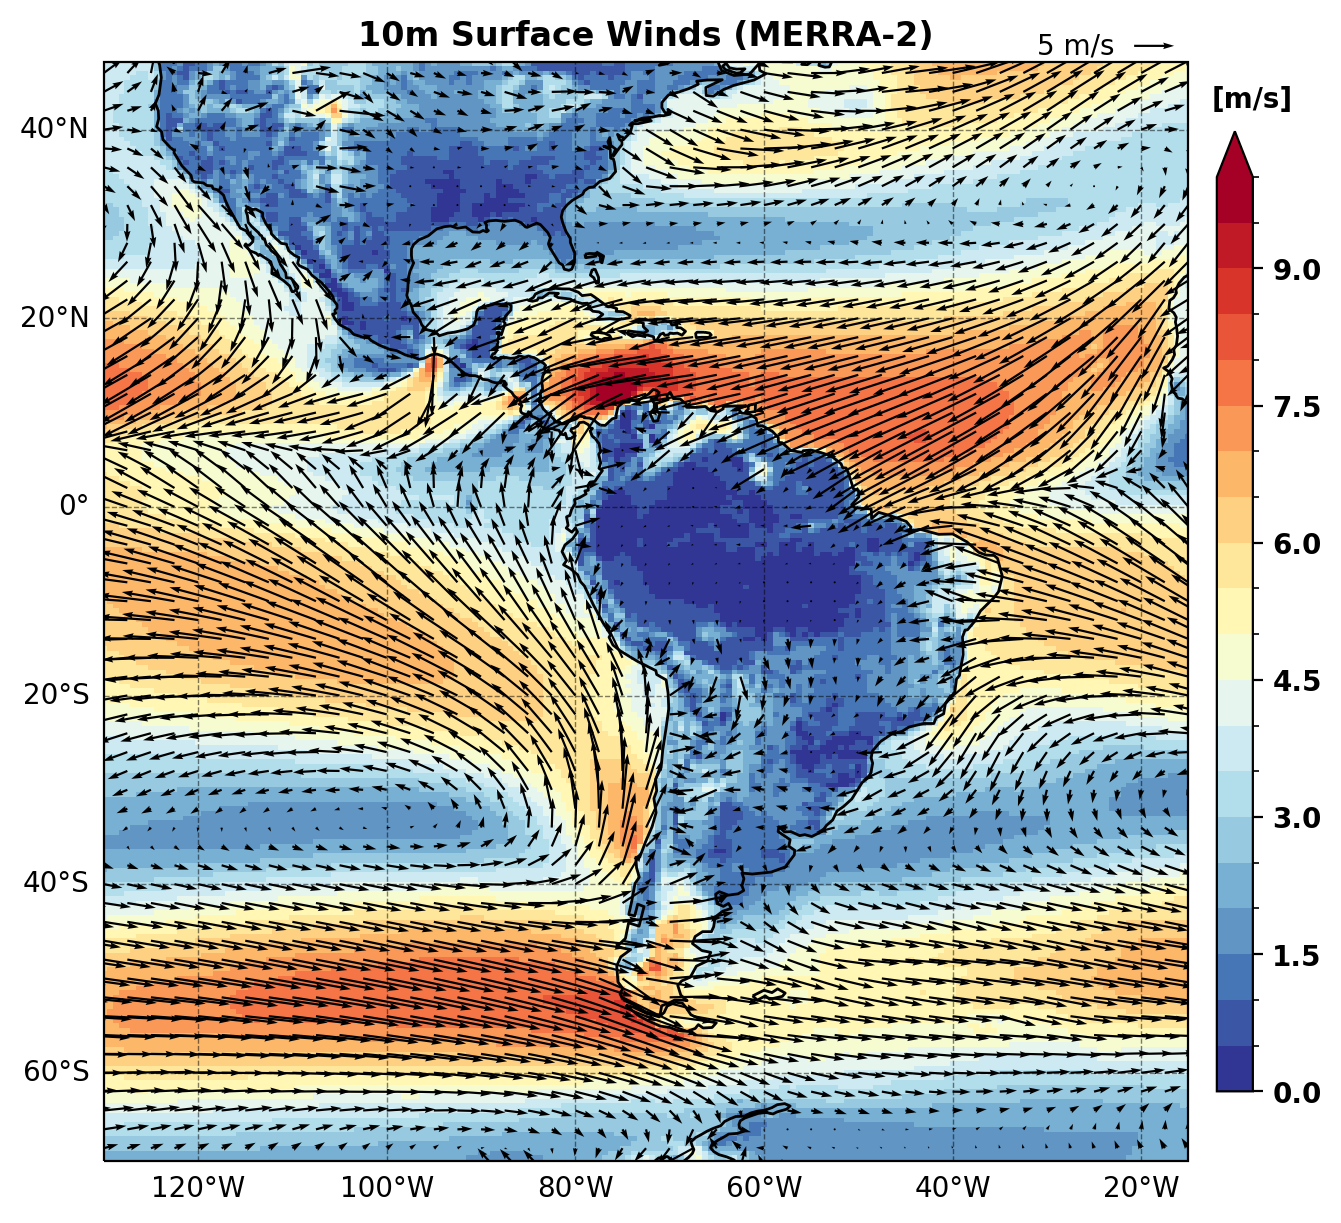

In [71]:
# Define vector properties
skip_n=4     # decrease the density of the arrows plotted
w=0.002      # arrow width
scalef=25     # scale of the arrows
key_length=5 # magnitude of the arrow key

# Define colormap and levels
cmap=cm.RdYlBu_r                               # pick color map
levels=np.linspace(0, 10, 21)                 # choose the number of levels to discretize the colorbar into
norm=mpl.colors.BoundaryNorm(levels, cmap.N)  # normalize the colormap to levels

# Define map projection and store boundaries in a variable
trans = ccrs.PlateCarree()
proj  = ccrs.PlateCarree()
map_bnds = [-130., -15., -55., 30.]

# Set figure and axes properties
fig = plt.figure(figsize=(6, 6), layout='constrained')
ax  = plt.subplot(111, projection=proj)
ax.set_title(("10m Surface Winds (MERRA-2)"), size=12, weight='bold')

# Plot wind speed contours using pcolormesh
cf=ax.pcolormesh(lon, lat, wndSpd10_seas.sel(season='DJF'), cmap=cmap, norm=norm, transform=trans)

# Plot wind speed direction using quiver
q1=ax.quiver(lon[::skip_n], lat[::skip_n], 
             u10_seas.sel(season='DJF')[::skip_n,::skip_n], v10_seas.sel(season='DJF')[::skip_n,::skip_n],
             color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=100)
# Create a reference arrow
qk=ax.quiverkey(q1, .95, 1.015, key_length, rf'{key_length} m/s', labelcolor='k', labelpos='W')

# Add coastlines and set map boundaries
ax.coastlines()
ax.set_extent(map_bnds)
gl = ax.gridlines(crs=trans, linewidth=.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.top_labels = False; gl.right_labels = False;

# Plot colorbar
cax=fig.add_axes([1.005, 0.1, 0.03, 0.8])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('[m/s]', y=1.1, labelpad=-25, rotation=0, size=10, fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize=10)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')

## Compare 2m and 10m wind speeds

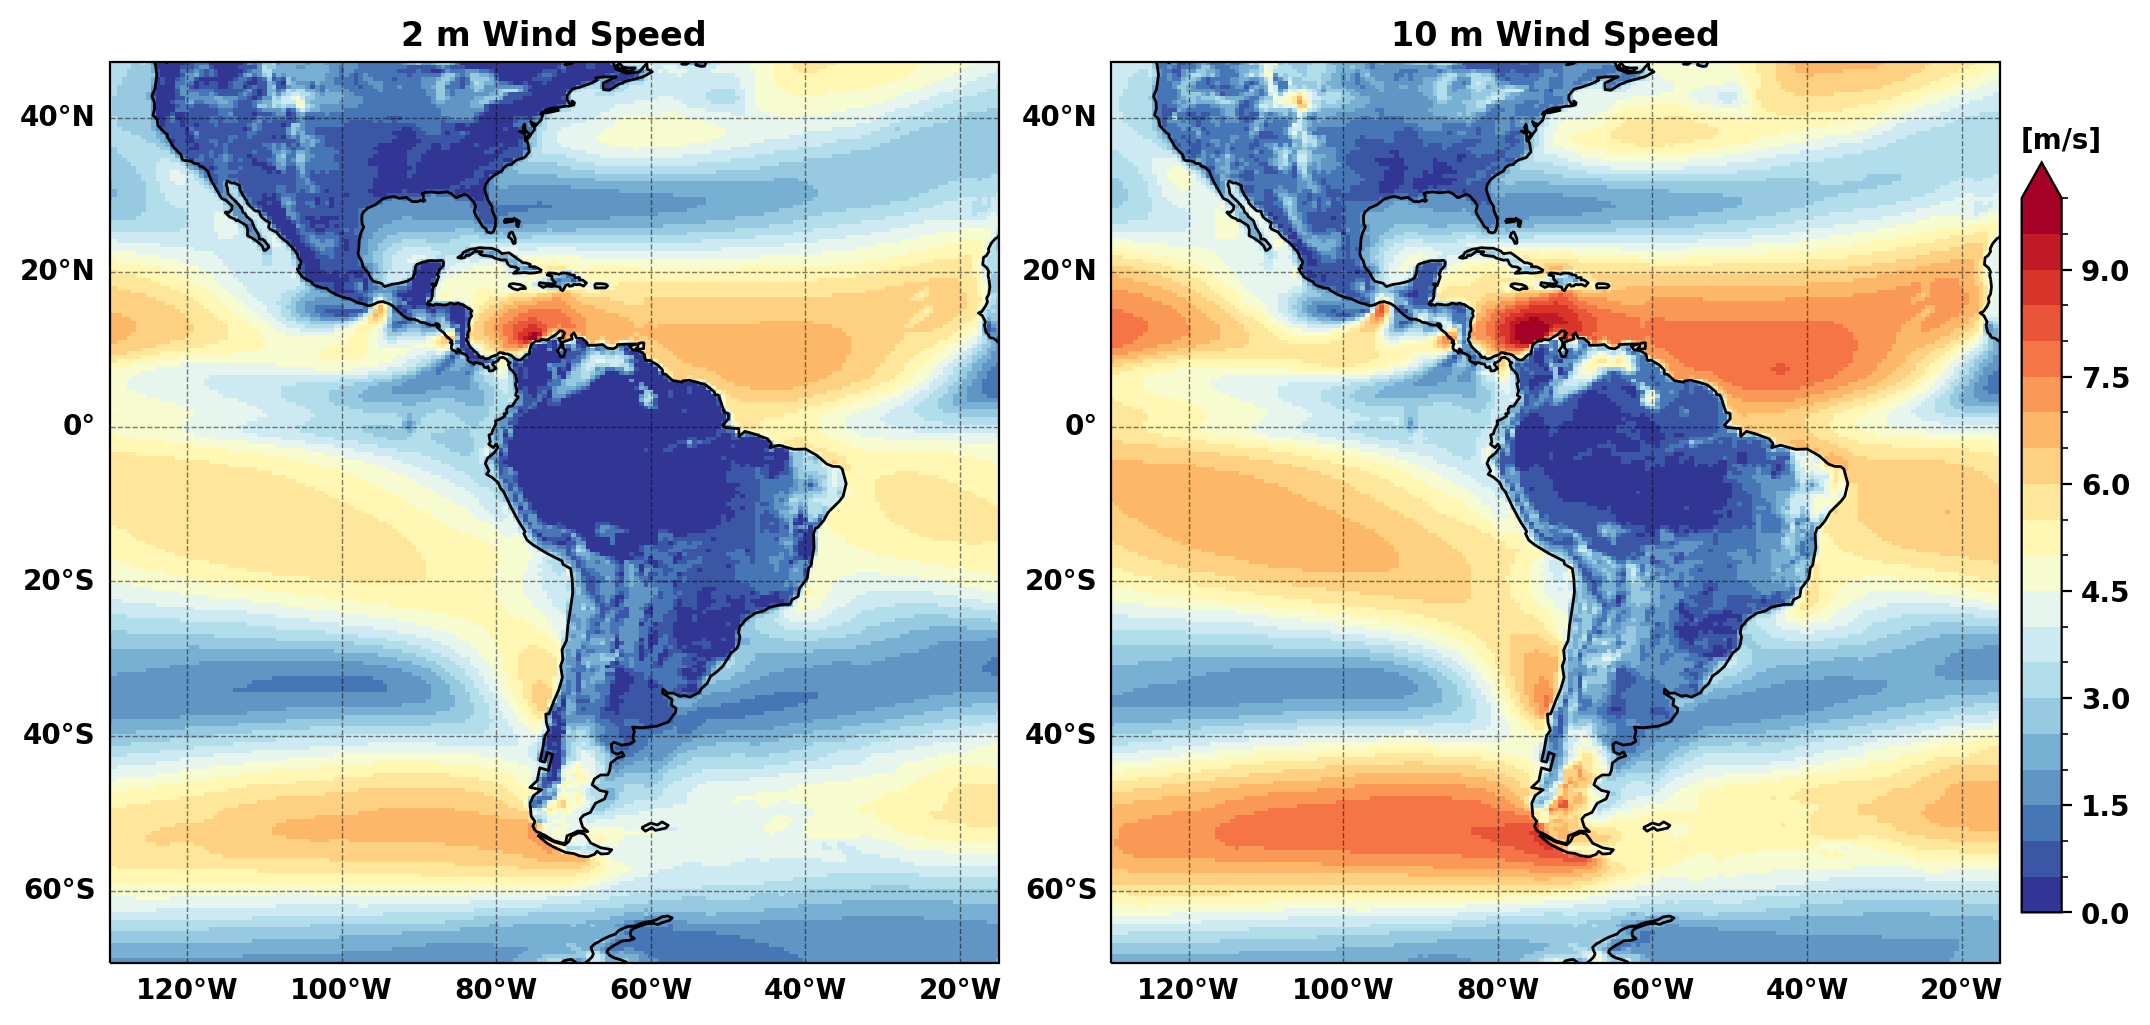

In [72]:
# Define colormap and levels
cmap=cm.RdYlBu_r                               # pick color map
levels=np.linspace(0, 10, 21)                 # choose the number of levels to discretize the colorbar into
norm=mpl.colors.BoundaryNorm(levels, cmap.N)  # normalize the colormap to levels

# Define map projection and store boundaries in a variable
trans = ccrs.PlateCarree()
proj  = ccrs.PlateCarree()
map_bnds = [-130., -15., -55., 30.]

# Set figure and axes properties
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), layout='constrained', subplot_kw={'projection':proj})

# Make plot of 2 m winds
ax[0].set_title('2 m Wind Speed', size=12, weight='bold')
cf=ax[0].pcolormesh(lon, lat, wndSpd2_seas.sel(season='DJF'), cmap=cmap, norm=norm, transform=trans)

# Make plot of 10 m winds
ax[1].set_title('10 m Wind Speed', size=12, weight='bold')
ax[1].pcolormesh(lon, lat, wndSpd10_seas.sel(season='DJF'), cmap=cmap, norm=norm, transform=trans)

# Add coastlines and set map boundaries
for i, ax in enumerate(ax.flat): 
    ax.coastlines()
    ax.set_extent(map_bnds)
    gl = ax.gridlines(crs=trans, linewidth=.5, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.top_labels = False; gl.right_labels = False;
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'bold', 'size':10}
    gl.ylabel_style={'color': 'black', 'weight': 'bold', 'size':10}

# Plot colorbar
cax=fig.add_axes([1.005, 0.1, 0.02, 0.75])
cbar=fig.colorbar(cf, orientation='vertical', extend='max', cax=cax)
cbar.set_label('[m/s]', y=1.1, labelpad=-25, rotation=0, size=10, fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize=10)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
